# 作業 : (Kaggle)鐵達尼生存預測
***

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to floa

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
train_X = df.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)

print(f'train_X.shape={train_X.shape}, test_X.shape={test_X.shape}, train_Y.shape={train_Y.shape}, test_Y.shape={test_Y.shape}')

train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

print(f'train_X.shape={train_X.shape}, val_X.shape={val_X.shape}, train_Y.shape={train_Y.shape}, val_Y.shape={val_Y.shape}')

train_X.shape=(445, 10), test_X.shape=(446, 10), train_Y.shape=(445,), test_Y.shape=(446,)
train_X.shape=(222, 10), val_X.shape=(223, 10), train_Y.shape=(222,), val_Y.shape=(223,)


# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

------

## sklearn.ensemble.RandomForestClassifie

```
class sklearn.ensemble.RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
```

A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).


### Parameters:	
#### n_estimators : integer, optional (default=10)
The number of trees in the forest.

Changed in version 0.20: The default value of n_estimators will change from 10 in version 0.20 to 100 in version 0.22.

#### criterion : string, optional (default=”gini”)
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.

#### max_depth : integer or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

#### min_samples_split : int, float, optional (default=2)
The minimum number of samples required to split an internal node:

If int, then consider min_samples_split as the minimum number.
If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
Changed in version 0.18: Added float values for fractions.

#### min_samples_leaf : int, float, optional (default=1)
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

If int, then consider min_samples_leaf as the minimum number.
If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.
Changed in version 0.18: Added float values for fractions.

#### min_weight_fraction_leaf : float, optional (default=0.)
The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

#### max_features : int, float, string or None, optional (default=”auto”)
The number of features to consider when looking for the best split:

If int, then consider max_features features at each split.
If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
If “auto”, then max_features=sqrt(n_features).
If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
If “log2”, then max_features=log2(n_features).
If None, then max_features=n_features.
Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

#### max_leaf_nodes : int or None, optional (default=None)
Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

#### min_impurity_decrease : float, optional (default=0.)
A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

The weighted impurity decrease equation is the following:

N_t / N * (impurity - N_t_R / N_t * right_impurity
                    - N_t_L / N_t * left_impurity)
where N is the total number of samples, N_t is the number of samples at the current node, N_t_L is the number of samples in the left child, and N_t_R is the number of samples in the right child.

N, N_t, N_t_R and N_t_L all refer to the weighted sum, if sample_weight is passed.

New in version 0.19.

#### min_impurity_split : float, (default=1e-7)
Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.

Deprecated since version 0.19: min_impurity_split has been deprecated in favor of min_impurity_decrease in 0.19. The default value of min_impurity_split will change from 1e-7 to 0 in 0.23 and it will be removed in 0.25. Use min_impurity_decrease instead.
#### bootstrap : boolean, optional (default=True)
Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree.

#### oob_score : bool (default=False)
Whether to use out-of-bag samples to estimate the generalization accuracy.

#### n_jobs : int or None, optional (default=None)
The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.

#### random_state : int, RandomState instance or None, optional (default=None)
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

#### verbose : int, optional (default=0)
Controls the verbosity when fitting and predicting.

#### warm_start : bool, optional (default=False)
When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest. See the Glossary.

#### class_weight : dict, list of dicts, “balanced”, “balanced_subsample” or None, optional (default=None)
Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.

Note that for multioutput (including multilabel) weights should be defined for each class of every column in its own dict. For example, for four-class multilabel classification weights should be [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of [{1:1}, {2:5}, {3:1}, {4:1}].

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

For multi-output, the weights of each column of y will be multiplied.

Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

### Attributes:	
#### estimators_ : list of DecisionTreeClassifier
The collection of fitted sub-estimators.

#### classes_ : array of shape = [n_classes] or a list of such arrays
The classes labels (single output problem), or a list of arrays of class labels (multi-output problem).

#### n_classes_ : int or list
The number of classes (single output problem), or a list containing the number of classes for each output (multi-output problem).

#### n_features_ : int
The number of features when fit is performed.

#### n_outputs_ : int
The number of outputs when fit is performed.

#### feature_importances_ : array of shape = [n_features]
Return the feature importances (the higher, the more important the feature).

#### oob_score_ : float
Score of the training dataset obtained using an out-of-bag estimate.

#### oob_decision_function_ : array of shape = [n_samples, n_classes]
Decision function computed with out-of-bag estimate on the training set. If n_estimators is small it might be possible that a data point was never left out during the bootstrap. In this case, oob_decision_function_ might contain NaN.

------

In [26]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
rf = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                            max_features=4, max_depth=3, bootstrap=True)

onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

"""
Your Code Here (Hint : 隨機森林的葉編碼(.apply)不需要加上[:, :, 0], 直接用rf.apply()調用即可, 本作業其餘寫法相同)
"""

# Note: 先用 GDBT 來做 fit / regression, 得到 tree 
rf.fit(train_X, train_Y)

print(f'rf.apply(train_X).shape={rf.apply(train_X).shape}')
rf.apply(train_X)

rf.apply(train_X).shape=(222, 20)


array([[ 6,  4,  9, ...,  8, 11, 10],
       [ 7,  6,  5, ...,  4,  3,  4],
       [ 3,  4,  8, ...,  8, 14, 10],
       ...,
       [ 3,  3,  8, ...,  8, 10, 14],
       [ 4,  4,  9, ...,  9, 13, 10],
       [11, 10, 11, ...,  8, 11, 10]], dtype=int64)

In [27]:
# Note: 先用 OneHot Encoder 來 Encode GDBT 的 Leaf
enc = onehot.fit(rf.apply(train_X))

print(f'enc.n_values_.shape={enc.n_values_.shape}')

enc.n_values_

enc.n_values_.shape=(20,)


C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function n_values_ is deprecated; The ``n_values_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function n_values_ is deprecated; The ``n_values_`` att

array([15, 15, 13, 15, 15, 15, 15, 13, 13, 15, 15, 15, 15, 15, 13, 13, 15,
       11, 15, 15])

In [28]:
enc.feature_indices_ 

C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function feature_indices_ is deprecated; The ``feature_indices_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


array([  0,  15,  30,  43,  58,  73,  88, 103, 116, 129, 144, 159, 174,
       189, 204, 217, 230, 245, 256, 271, 286], dtype=int32)

In [29]:
# Note: 先用 OneHot Encoder 來 Encode RF 的 Leaf
onehot.fit(rf.apply(train_X))

C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [30]:
# Note: 然後再用 Logistic Regression 來 fit OneHot Encoder 的結果
lr.fit(onehot.transform(rf.apply(val_X)), val_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
"""
Your Code Here 
"""
# predict_proba: Probability estimates
# fpr: False Positve Rate
# tpr: True Positve Rate
pred_rf_lr = lr.predict_proba(   onehot.transform(rf.apply(test_X))  )[:, 1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(test_Y, pred_rf_lr)

# 將隨機森林結果輸出
"""
Your Code Here 
"""
pred_rf = rf.predict_proba(test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_Y, pred_rf)


# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?

> Answer: Yes, 看起來有提高正確性

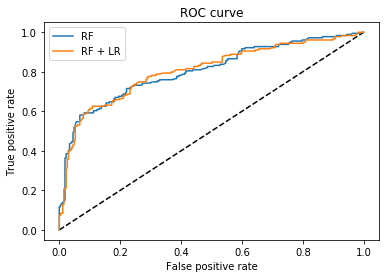

In [35]:
import matplotlib.pyplot as plt
# 將結果繪圖
"""
Your Code Here 
"""

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()